In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats

### Шаг 1. Откройте файл с данными и изучите общую информацию
Путь к файлу: /datasets/logs_exp.csv. Скачать датасет

In [2]:
# Загрузим датасет
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv(r'C:\Users\User\OneDrive\Education\1_Ya_DA\14_prefabricated_project\logs_exp.csv', sep='\t')

In [3]:
# Выведем первые пять строк
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# Выведем информацию о фрейме данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Шаг 2. Подготовьте данные
- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат

- Замените названия столбцов на удобные для вас;

In [5]:
# В соответствии с хорошим стилем, укажем названия колонок в нижнем регистре
df.columns = ['event_name', 'device_id', 'event_time', 'group_id']

In [6]:
# Выведем количество пропусков
print('Количество пропусков: ', df.isna().sum().sum())

Количество пропусков:  0


In [7]:
# Выведем количество дубликатов
print('Количество дубликатов: ', df.duplicated().sum())

Количество дубликатов:  413


In [8]:
# Удалим явные дубликаты, обновим индекс
df = df.drop_duplicates().reset_index(drop=True)


In [9]:
# Преобразуем временные данные
df['date_time'] = pd.to_datetime(df['event_time'], unit='s')
df['date'] = pd.to_datetime(df['date_time']).dt.date

In [10]:
# Проверим, всё ли у нас получилось
df.head()

,event_name,device_id,event_time,group_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
# Выведеи информацию по обновлённому фрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  int64         
 3   group_id    243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


Вывод

Загрузили данные. Заменили названия колонок. Пропусков нет. Дубликаты в количестве 413 шт. удалили. Добавили колонку с датами. Преобразовали колонку event_time в читаемый вид даты. Обработанные данные позволят нам провести анализ и сделать выводы.


### Шаг 3. Изучите и проверьте данные
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [12]:
def study_and_verification_of_data(data):
    """ Создадим функцию с print`ами для вывода
    нужной информации
    """
    
    print('Количество событий в логе: ', data['event_name'].nunique())
    print('Количество пользователей в логе: ', data['device_id'].nunique())
    print('Среднее количество событий на пользователя: ', round(data.groupby('device_id')['event_name'].count().mean(), 2))
    print('Количество дней в логе:', data['date'].max() - data['date'].min() + timedelta(days=1))
    print('Максимальная дата: ', data['date'].max())
    print('Минимальная дата: ', data['date'].min())
    print('Количество экспериментальных групп в логе: ', data['group_id'].nunique())


study_and_verification_of_data(df)

Количество событий в логе:  5
Количество пользователей в логе:  7551
Среднее количество событий на пользователя:  32.28
Количество дней в логе: 14 days, 0:00:00
Максимальная дата:  2019-08-07
Минимальная дата:  2019-07-25
Количество экспериментальных групп в логе:  3


Text(0, 0.5, 'Количество событий')

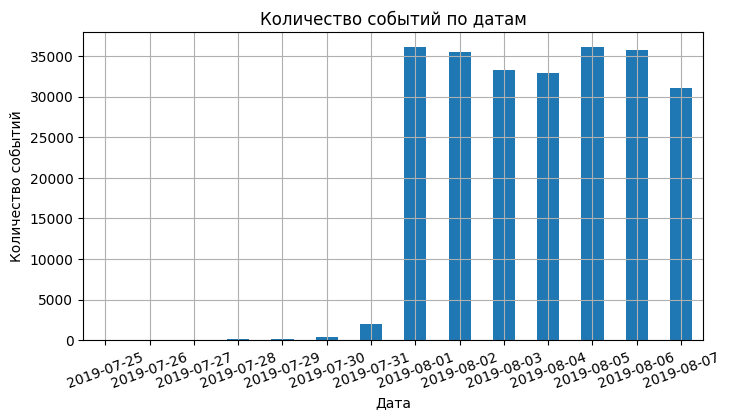

In [13]:
# Построим гистограмму по дате и времени
fig, ax = plt.subplots()

(df
    .groupby('date')['event_name']
    .count()
    .plot(kind='bar'
        , rot=20
        , figsize=(8, 4)
        , grid = True)
)

ax.set_title('Количество событий по датам', fontsize=12)
ax.set_xlabel('Дата', fontsize=10)
ax.set_ylabel('Количество событий', fontsize=10)

Исключим из анализа дни с неполными данными - все дни до 2019-08-01.

In [14]:
# Преобразуем временные данные
days_with_complete_data = pd.Timestamp('2019-08-01').date()

# Создадим новый фрейм данных с датой событий от 1 августа 2019 г.
df_new = df.query('date >= @days_with_complete_data')

# Посмотрим, что у нас получилось
df_new.head()

,event_name,device_id,event_time,group_id,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Выведем на экран результат функции с обновлёнными данными

In [15]:
study_and_verification_of_data(df_new)

Количество событий в логе:  5
Количество пользователей в логе:  7534
Среднее количество событий на пользователя:  31.97
Количество дней в логе: 7 days, 0:00:00
Максимальная дата:  2019-08-07
Минимальная дата:  2019-08-01
Количество экспериментальных групп в логе:  3


Посмотрим, какое количество исключенных событий, пользователей

In [16]:
# Посчитаем и выведем количество исключенных событий
print('Исключили {} событий, или {:.2%}'.format(df.shape[0] - df_new.shape[0]
                                        , (df.shape[0] - df_new.shape[0]) / df.shape[0]))

Исключили 2826 событий, или 1.16%


In [17]:
# Посчитаем и выведем количество исключенных пользователей
print('Исключили {} пользователей, или {:.2%}'.format(df['device_id'].nunique() - df_new['device_id'].nunique()
                                        , (df['device_id'].nunique() - df_new['device_id'].nunique()) / df['device_id'].nunique()))

Исключили 17 пользователей, или 0.23%


Вывод

Получены данные за 14 дней, за этот период произошло 243 713 событий. Построили гистограмму, получили картину с неполными даннными, отсеяли их, оставили 7 дней полных данных. Количетво событий сократилось на 2 826 до 240 887.   
Отсеяли 17 пользователей из 7 551 осталось 7 534.   
Количество групп не изменилось.

### Шаг 4. Изучите воронку событий

- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

Наименование событий:
- 'Tutorial' - 'Учебное пособие', 
- 'Main Screen Appear' - 'Появился главный экран', 
- 'Offers Screen Appear' - 'Появился экран предложений',
- 'Cart Screen Appear' - 'Появился экран корзины', 
- 'Payment Screen Successful' - 'Экран завершения оплаты'.

In [18]:
# Выведем группировку по убыванию количества событий
(
    df_new
        .groupby('event_name', as_index=False)['device_id']
        .count()
        .sort_values('device_id', ascending=False)
        .rename(columns={'device_id' : 'count'})
        .reset_index(drop=True)
)


,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Tutorial происходит где-то между главным экраном и корзиной, то есть пользователи могут посмотреть инструкцию сразу как зашли в приложение или перейти с экрана витрины. Так как в хронологии не понятно где событие Tutorial, то для расчета воронки отбросим это событие.

In [19]:
# Применим фильтрацию
df_new = df_new.query('event_name != "Tutorial"')

- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.


In [20]:
# Отсортируем события по количеству пользователей
conversion = (
                df_new
                    .groupby('event_name', as_index=False)['device_id']
                    .nunique()
                    .sort_values('device_id', ascending=False)
                    .rename(columns={'device_id' : 'user_unique'})
                    .reset_index(drop=True)
)
conversion

,event_name,user_unique
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [21]:
conversion['user_share_%'] = (
    conversion['user_unique'] / df_new['device_id'].nunique() * 100
    ).round(2)

conversion

,event_name,user_unique,user_share_%
0,MainScreenAppear,7419,98.53
1,OffersScreenAppear,4593,61.00
2,CartScreenAppear,3734,49.59
3,PaymentScreenSuccessful,3539,47.00


- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Порядок выполнения событий:

1. Tutorial - Учебное пособие
2. MainScreenAppear - Появился главный экран        
3. OffersScreenAppear - Появился экран предложений     
4. CartScreenAppear - Появился экран корзины
5. PaymentScreenSuccessful - Экран Оплата прошла успешно        

- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [22]:
# Создадим список с событиями, которые включим в воронку и отфильтруем датасет по ним
list_of_events = [event for event in df_new.event_name.unique() if 'Screen' in event]
list_of_events

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [23]:
# Сделаем фрейм данных для списка событий
df_new_funnel = df_new[df_new.event_name.isin(list_of_events)]

In [24]:
# Отсортируем события в порядке убывания
df_new_funnel.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

In [25]:
# Посчитаем количество уникальных пользователей для каждого события
df_new_funnel = (
    df_new_funnel
        .groupby('event_name')['device_id']
        .nunique()
        .reset_index()
    )
df_new_funnel

,event_name,device_id
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539


In [26]:
# Отсортируем пользователей в порядке убывания
sorting = df_new_funnel.sort_values(by='device_id', ascending=False)
sorting

,event_name,device_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [27]:
# Посчитаем долю пользователей переходящих с текущего шага воронки на следующий
sorting['fraction'] = (
    sorting['device_id'] / sorting['device_id'].shift(1)
)

sorting['fraction'] = (
    sorting['fraction'] * 100).round(2).map('{0:.2f}%'.format
)

sorting

,event_name,device_id,fraction
1,MainScreenAppear,7419,nan%
2,OffersScreenAppear,4593,61.91%
0,CartScreenAppear,3734,81.30%
3,PaymentScreenSuccessful,3539,94.78%


Видим последовательные переходы по цепочке событий: MainScreenAppear > OffersScreenAppear (61.91 %) > CartScreenAppear (81.30 %) > PaymentScreenSuccessful (94.78 %)

- На каком шаге теряете больше всего пользователей?

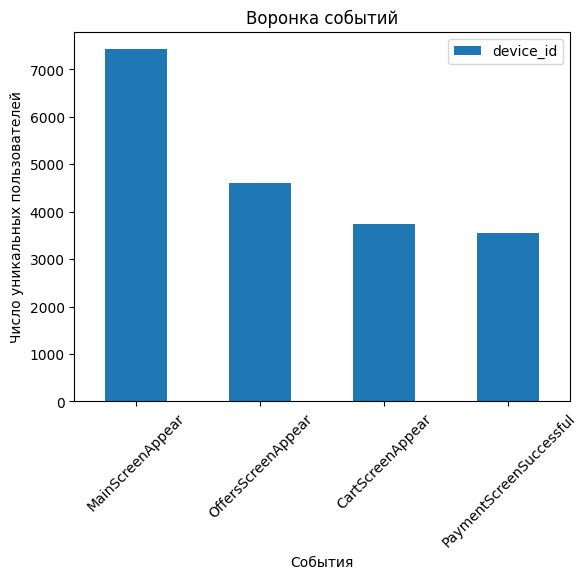

In [28]:
# Построим график воронки для наглядности

df_new_funnel.sort_values('device_id', ascending=False).plot(kind='bar', x='event_name')

plt.title('Воронка событий')
plt.xlabel('События')
plt.xticks(rotation=45)
plt.ylabel('Число уникальных пользователей')

plt.show()

Наибольшие потери между первым (MainScreenAppear) и вторым (OffersScreenAppear) шагом.

- Какая доля пользователей доходит от первого события до оплаты?

Доля пользователей доходящих от первого события до оплаты, составляет - 38.09 %.

### Шаг 5. Изучите результаты эксперимента

- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

- Сколько пользователей в каждой экспериментальной группе?

In [29]:
# Применим группировку с агрегированием данных
df_new.groupby('group_id').agg({'device_id': ['count', 'nunique']})

device_id        
             count nunique
group_id                  
246          78985    2483
247          76684    2512
248          84213    2535

В каждой экспериментальной группе примерно одинаковое число участников ~ 2 500.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

В тесте пользователи контрольных групп - 246, 247 и пользователи экспериментальной группы - 248.

In [30]:
# Вычислим % разницы между выборками
group_246 = (
    df_new
        .query('group_id == 246')
        .groupby('group_id')['device_id']
        .nunique()
        .reset_index()
)

group_247 = (
    df_new
        .query('group_id == 247')
        .groupby('group_id')['device_id']
        .nunique()
        .reset_index()
)

difference = 1 - group_246.iloc[0]['device_id'] / group_247.iloc[0]['device_id']

print('Разница между выборками 246 и 247 - {:.2%}'.format(difference))

Разница между выборками 246 и 247 - 1.15%


Разница между выборками 246 и 247 небольшая,  около 1%, что является приемлемым значением для контрольных групп.

- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [31]:
# Посмотрим, сколько пользователей совершали каждое событие в каждой 
# экспериментальной группе
(
    df_new
        .pivot_table(index='event_name'
            , columns='group_id'
            , values='device_id'
            , aggfunc='nunique')
)

group_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


Самое популярное событие - MainScreenAppear. Тут большой разницы между количеством пользователей нет.

Сформулируем гипотезы:

Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы;

Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы;

Пороговое значение alpha примем за 5%.

In [32]:
def a_b_calc(df, group_ids, alpha):
    """функция считает статистическую значимость между группами. 
    Фрейм данных обработаем внутри функции, группы передадим 
    в виде списка
    """

    # найдем уникальных пользователей в каждой группе
    users = ([df.query('group_id == @group_id')['device_id']
                .nunique() for group_id in group_ids]
    )
    
    # перебираем все экспериментальные группы для каждого события, считаем 
    # количество пользователей и долю
    for event in df.event_name.unique():
        events =([df.query('group_id == %d and event_name == "%s"' % (group_id, event))['device_id']
                    .nunique() for group_id in group_ids]
        )

        # сравниваем кол-во уникальных юзеров на каждом шаге группы 
        # к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] # считаем долю для 1 группы
        p2 = events[1] / users[1] # считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / math.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) # считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distribution = stats.norm(0, 1) # распределение
        
        p_value = (1 - distribution.cdf(abs(z_value))) * 2 # считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)

        # сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print('-------------------------------------------------------------------')
        print(' ')


Проведём A/A тестирование - это проверка всего эксперимента на валидность

In [33]:
# Посмотрим на события в группах 246 и 247
a_b_calc(df_new, [246, 247], 0.05)

MainScreenAppear
0.9867096254530809 0.9856687898089171
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
OffersScreenAppear
0.6210229561014902 0.6050955414012739
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
CartScreenAppear
0.5098670962545309 0.4928343949044586
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
PaymentScreenSuccessful
0.4832863471606927 0.4609872611464968
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разны

Различия между экспериментальными контрольными группами 246 и 247, совершившими все события статистически не значимы. Пользователи однородно распределились, сделаем сравнение любой из этих групп с тестовой группой - 248.

- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?


Перейдём к A/B тесту - важно понять, есть ли у нас статистически значимые различия.

Проверим три возможные комбинации А-групп и B-группы. В этом блоке проводим несколько последовательных сравнений, с каждым из них увеличиваем свои шансы ошибиться - "проблема множественных сравнений". Во избежание этого, используем поправку Бонферрони - поделим alpha на количество проведенных проверок. У нас 16 возможных вариантов событий.



In [34]:
# Посмотрим на события в 246 и 248 группах
a_b_calc(df_new, [246, 248], 0.05 / 16)

MainScreenAppear
0.9867096254530809 0.9834319526627219
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
OffersScreenAppear
0.6210229561014902 0.6039447731755424
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
CartScreenAppear
0.5098670962545309 0.48520710059171596
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
PaymentScreenSuccessful
0.4832863471606927 0.4658777120315582
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разн

Различия между группами 246 и 248 совершившими все события статистически не значимы. Высокое p-value означает, что мы имеем высокую вероятность случайных различий между показателями, обусловленных обычной дисперсий в данных, а не реальной разницей.

In [35]:
# Посмотрим на события в 247 и 248 группах
a_b_calc(df_new, [247, 248], 0.05 / 16)

MainScreenAppear
0.9856687898089171 0.9834319526627219
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
OffersScreenAppear
0.6050955414012739 0.6039447731755424
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
CartScreenAppear
0.4928343949044586 0.48520710059171596
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
PaymentScreenSuccessful
0.4609872611464968 0.4658777120315582
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными

Различия между экспериментальными группами 247 и 248 совершившими все события статистически не значимы. Р-value больше 0.05 - группы не имеют различий.

In [36]:
# Объединим две контрольные группы в одну и оставим ее под номером 246.
df_new_combined = df_new.copy()

df_new_combined["group_id"].replace({247: 246}, inplace=True)

df_new_combined["group_id"].value_counts()

246    155669
248     84213
Name: group_id, dtype: int64

In [37]:
# Посмотрим на события в объединенной контрольной группе 246 и 248 группе.
a_b_calc(df_new_combined, [246, 248], 0.05 / 16)

MainScreenAppear
0.9861861861861861 0.9834319526627219
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
OffersScreenAppear
0.613013013013013 0.6039447731755424
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
CartScreenAppear
0.5013013013013013 0.48520710059171596
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------------------------------------------
 
PaymentScreenSuccessful
0.4720720720720721 0.4658777120315582
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разным

Различия между объединенными группами 246, 247 и группой 248 совершившими все события статистически не значимы.

### Общий вывод

Предоставлены данные A/А, A/B-тестирования с двумя контрольными группами и одной тестовой, на основании которых требовалось выяснить повлияет ли на действия пользователей изменение шрифта мобильного приложения.

В процессе анализа изучили данные из логов, удалили из данных дубликаты, выявили актуальный временной период, построили воронку событий, сформулировали и отработали гипотезы.

Проведённый анализ показал, что разницы между долями пользователей в контрольных группах 
и контрольной/тестовой группах нет.

На основании проведенного анализа делаем вывод, что изменение шрифта не повлияло на пользователей.